## IMPORT LIBRARIES

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import LinearSVC
import warnings
warnings.filterwarnings('ignore')

## LOAD & CLEAN DATA

In [10]:
df = pd.read_csv("/content/tiktok_google_play_reviews.csv")
df.head()


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,68ccaec8-1415-4301-a85e-3004679a3a83,Cassie Moore,https://play-lh.googleusercontent.com/a/ALm5wu...,No words,5,0,27.1.3,2022-11-29 21:55:37,NaN,NaN
1,d84cbfd3-6aa3-485c-aaf9-c5dca27dc966,Kaleb Plummer,https://play-lh.googleusercontent.com/a-/ACNPE...,Great fun app so far!,5,0,NaN,2022-11-29 21:55:04,NaN,NaN
2,96618aa1-31e5-4259-8649-89b75d962f00,Rylee Maher,https://play-lh.googleusercontent.com/a/ALm5wu...,The app would get a higher rating but I litera...,1,0,27.1.3,2022-11-29 21:54:48,NaN,NaN
3,078c0bda-598b-474e-a04e-d7cb3e6f6301,Kittykatelyn Romilly,https://play-lh.googleusercontent.com/a-/ACNPE...,I WISH I COULD GIVE THIS A 100 PERCENT RATING ...,5,0,NaN,2022-11-29 21:54:35,NaN,NaN
4,8e68c5cd-b12a-4206-a8da-6bfdbff44ae3,Loveness Malenga,https://play-lh.googleusercontent.com/a-/ACNPE...,Pictures and record,5,0,NaN,2022-11-29 21:54:21,NaN,NaN


In [11]:
print(df.columns)

Index(['reviewId', 'userName', 'userImage', 'content', 'score',
       'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent',
       'repliedAt'],
      dtype='object')


In [13]:
# Check the relevant columns
df.dropna(subset=['content', 'score'], inplace=True)

# Create a binary label: 1 for positive (score > 3), 0 for negative (score < 3)
df['label'] = df['score'].apply(lambda x: 1 if x > 3 else 0)

# Clean the review content
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

df['clean_review'] = df['content'].astype(str).apply(clean_text)

### Visualizations

#### Sentiment Distribution

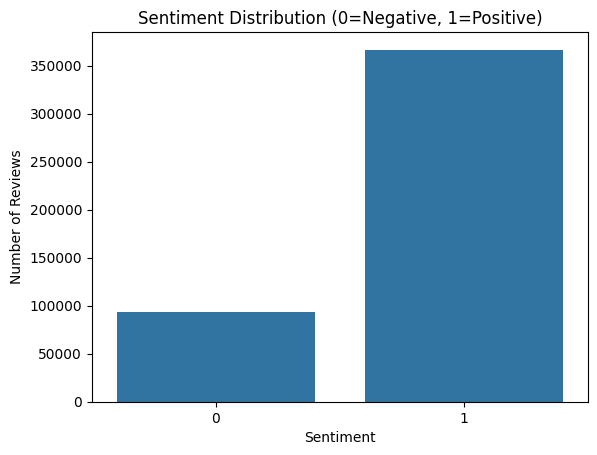

In [14]:
sns.countplot(x='label', data=df)
plt.title("Sentiment Distribution (0=Negative, 1=Positive)")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()

#### Sentiment Ratio

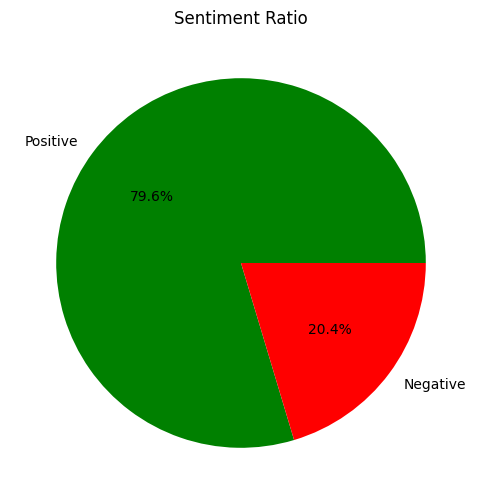

In [15]:
label_counts = df['label'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(label_counts, labels=['Positive', 'Negative'], autopct='%1.1f%%', colors=['green', 'red'])
plt.title('Sentiment Ratio')
plt.show()

#### Word Clouds

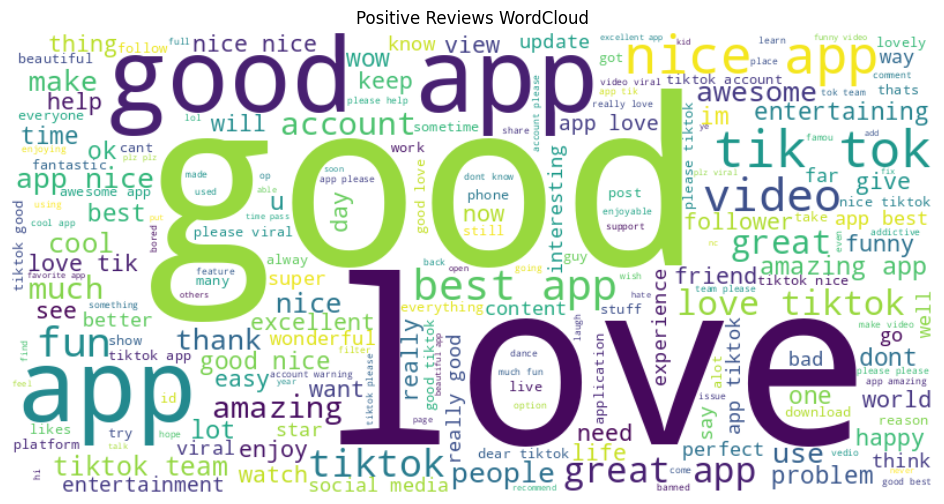

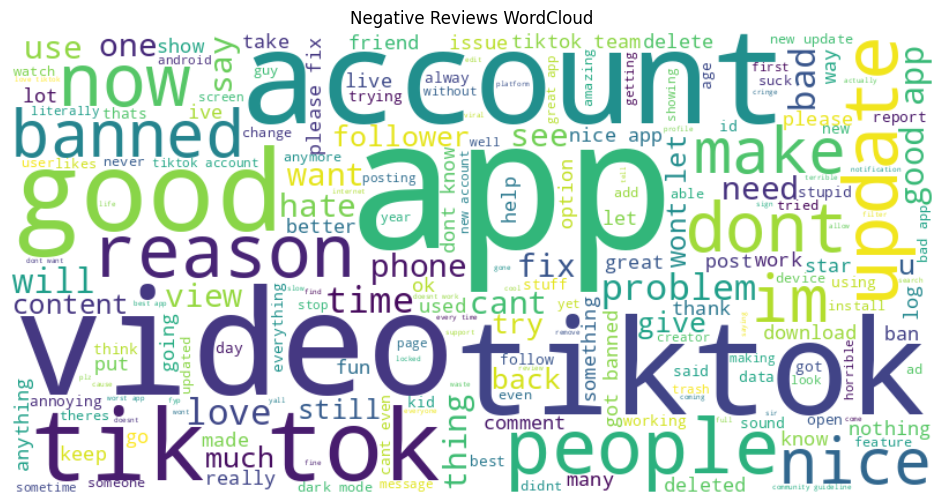

In [16]:
# Create stopwords set
stopwords = set(STOPWORDS)

# Create the full text for each class
positive_text = " ".join(df[df['label'] == 1]['clean_review'])
negative_text = " ".join(df[df['label'] == 0]['clean_review'])

# Generate WordClouds
positive_wc = WordCloud(width=800, height=400, background_color='white',
                        stopwords=stopwords).generate(positive_text)

negative_wc = WordCloud(width=800, height=400, background_color='white',
                        stopwords=stopwords).generate(negative_text)

# Use matplotlib to display
plt.figure(figsize=(12, 6))
plt.imshow(positive_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews WordCloud')
plt.show()

plt.figure(figsize=(12, 6))
plt.imshow(negative_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews WordCloud')
plt.show()

#### LINE PLOT OF REVIEW LENGTH

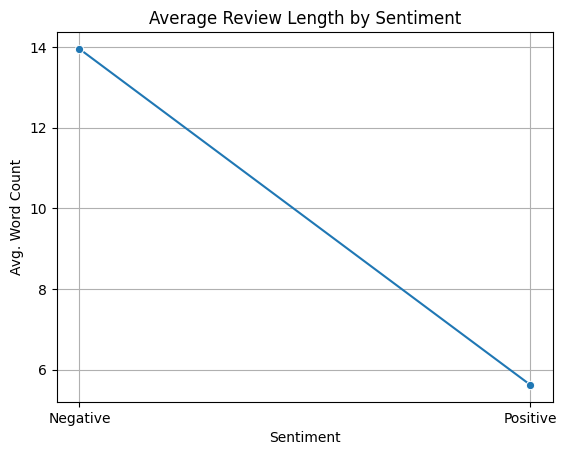

In [17]:
df['review_length'] = df['clean_review'].apply(lambda x: len(x.split()))
avg_length = df.groupby('label')['review_length'].mean().reset_index()

sns.lineplot(data=avg_length, x='label', y='review_length', marker='o')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.title("Average Review Length by Sentiment")
plt.ylabel("Avg. Word Count")
plt.xlabel("Sentiment")
plt.grid(True)
plt.show()

In [19]:
df.columns

Index(['reviewId', 'userName', 'userImage', 'content', 'score',
       'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent',
       'repliedAt', 'label', 'clean_review', 'review_length'],
      dtype='object')

## FEATURE EXTRACTION (TF-IDF)

In [21]:
tfidf = TfidfVectorizer(max_features=1000)
X = tfidf.fit_transform(df['clean_review'])  # Keep as sparse
y = df['label']

## SPLIT DATA

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Model Training & Evaluation

In [23]:
# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)


In [26]:
# SVM Model
svm = LinearSVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

In [27]:
# Accuracy scores
acc_lr = accuracy_score(y_test, y_pred_lr)
acc_svm = accuracy_score(y_test, y_pred_svm)

# Dataframe for comparison
model_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'SVM (Linear)'],
    'Accuracy': [acc_lr, acc_svm]
})

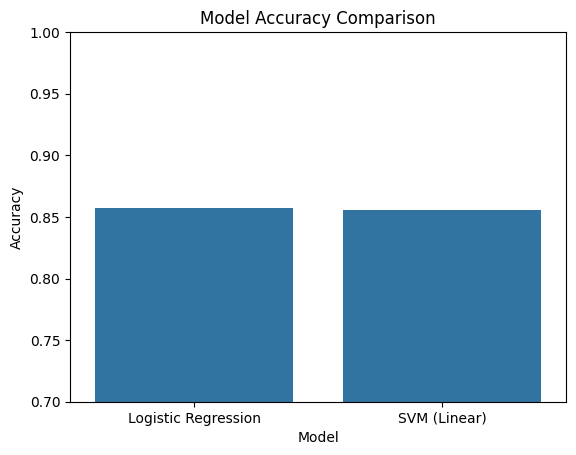

In [28]:
# Barplot
sns.barplot(x='Model', y='Accuracy', data=model_df)
plt.title('Model Accuracy Comparison')
plt.ylim(0.7, 1.0)
plt.ylabel("Accuracy")
plt.show()

In [29]:
print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr))

print("\n=== SVM (Linear) ===")
print(classification_report(y_test, y_pred_svm))


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.77      0.42      0.55     18771
           1       0.87      0.97      0.92     73281

    accuracy                           0.86     92052
   macro avg       0.82      0.70      0.73     92052
weighted avg       0.85      0.86      0.84     92052


=== SVM (Linear) ===
              precision    recall  f1-score   support

           0       0.77      0.41      0.54     18771
           1       0.87      0.97      0.91     73281

    accuracy                           0.86     92052
   macro avg       0.82      0.69      0.73     92052
weighted avg       0.85      0.86      0.84     92052

